In [11]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

In [12]:
# All kernels a(k, q) are translation and rotation invariant.

In [13]:
# Define some kernels as shown in the notes
def gaussian(x):
    return torch.exp(-(x**2) / 2)


def boxcar(x):
    return torch.abs(x) < 1.0


def constant(x):
    return 1.0 + 0 * x


def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

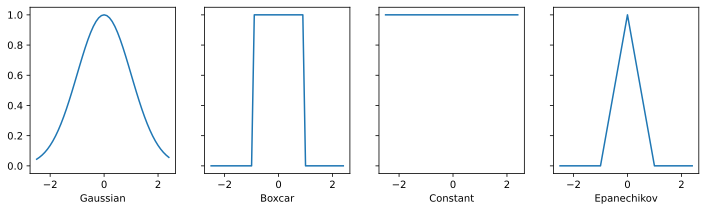

In [14]:
# Plotting them to see
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
kernels = (gaussian, boxcar, constant, epanechikov)
names = ("Gaussian", "Boxcar", "Constant", "Epanechikov")
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)
d2l.plt.show()

# We see how each kernel accords attention and in what range
# - Boxcar accords full attention to only those observations within a distance of 1 and does so indiscriminately
# - Epanechikov accords attention to observations which are exact
# - Gaussian smoothly accords more attention to similar observations and less to dissimilar ones
# - Constant attends same attention to all observations

In [15]:
# Define some training data
def f(x):
    return 2 * torch.sin(x) + x


n = 40
# Training
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)

# Validation
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

In [16]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    """
    Attention pooling: Here
    Query: kernel
    x_train: key
    y_train: value
    """
    # First we perform kernel over all training features(covariates) x_train and all validation features x_val
    # This is done for diagnostic purposes
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))

    # Each column/row corresponds to query/key
    k = kernel(dists).type(torch.float32)
    # Normalizing over keys for each query to get atention weights
    attention_w = k / k.sum(0)
    y_hat = y_train @ attention_w
    return y_hat, attention_w

In [29]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap="Reds")
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, "m--")
            ax.plot(x_train, y_train, "o", alpha=0.5)
        ax.set_xlabel(name)
        if not attention:
            ax.legend(["yhat", "y"])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

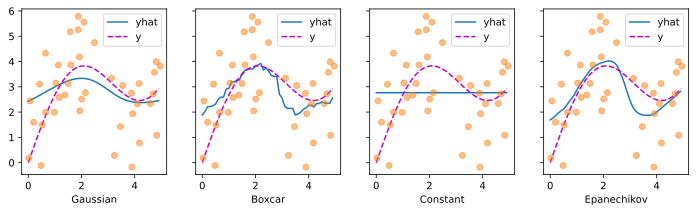

In [30]:
plot(x_train, y_train, x_val, y_val, kernels, names)

# Only the constant kernel produces out-rageous results

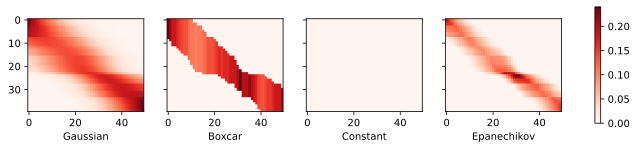

In [32]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)
# This shows their attention weights and we can see that except for the constant kernel, the rest are similar and thus similar predictions as shown above

**Adapting Attention Pooling**


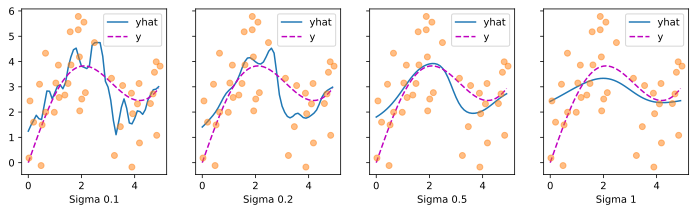

In [35]:
# Last time the gaussian kernel had a width of 1 i.e sigm = 1, but we will
# vary it to see how it affects the plots and attention weights
sigmas = (0.1, 0.2, 0.5, 1)
names = ["Sigma " + str(sigma) for sigma in sigmas]


def gaussian_with_width(sigma):
    return lambda x: torch.exp(-(x**2) / (2 * sigma**2))


kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

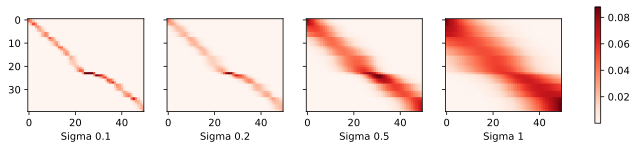

In [36]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)


## Well Needed summary, Why this???

- This is explored because it one of the earliest precursors to attention mechanisms, great for visualization and it was to show the limit of hand-crafting attention mechanisms

- Nadaraya–Watson kernel regression is an early precursor of the current attention mecha-
nisms. It can be used directly with little to no training or tuning, either for classification or
regression. 

- The attention weight is assigned according to the similarity (or distance) between query and key, and according to how many similar observations are available.